In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Preparing metadata (setup.py) ... done
  Created wheel for colabgymrender: filename=colabgymrender-1.0.2-py3-none-any.whl size=2425 sha256=57116108723125e16a97e0ee405f9fb3930a9e49a60078269cb14c10b04242ee
  Stored in directory: /root/.cache/pip/wheels/54/1d/51/d65a99106096dd07e3be6f08d5d3c2dd5f26ac98f626e5efc9
Successfully built colabgymrender


In [ ]:
from colabgymrender.recorder import Recorder

  np.bool8: (False, True),

  from scipy.ndimage.filters import sobel



In [ ]:
# install dependencies
!apt install chromium-browser xvfb

  and should_run_async(code)



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apparmor libfontenc1 libfuse3-3 liblzo2-2 libudev1 libxfont2 libxkbfile1 snapd squashfs-tools
  systemd-hwe-hwdb udev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils xserver-common
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chromium-browser libfontenc1 libfuse3-3 liblzo2-2 libxfont2 libxkbfile1 snapd
  squashfs-tools systemd-hwe-hwdb udev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
The following packages will be upgraded:
  libudev1
1 upgraded, 17 newly installed, 0 to remove and 44 not upgraded.
Need to get 36.2 MB of archives.
After this operation, 129 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 apparmor amd64 3.0.4-2ubuntu2.3 [595 kB]


In [ ]:
env = gym.make('CartPole-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


  logger.warn(

  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



33.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
total_reward

  and should_run_async(code)



33.0

In [ ]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 50000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount
alpha = 5e-4 # learning rate

memory_size = 50000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 1000 # target network update frequency

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.Tanh(),
            nn.Linear(128, env.action_space.n)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [ ]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [ ]:

def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []

    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

# Train CartPole-v1

In [ ]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

  states = torch.tensor(states, dtype=torch.float32)



KeyboardInterrupt: 

In [ ]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [ ]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

# MountainCar-v0

In [ ]:
class MountainCar_NN(nn.Module):
    def __init__(self, env):
        super(MountainCar_NN, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, env.action_space.n)
        )
        # self.network = nn.Sequential(
        #     nn.Linear(env.observation_space.shape[0], 128),
        #     nn.ReLU(),
        #     nn.Linear(128, env.action_space.n)
        # )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [ ]:
def fill_memory2(env):
    memory = deque(maxlen=memory_size2)
    state = env.reset()
    for _ in range(min_replay_size2):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [ ]:
def MountainCar_DQN(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = MountainCar_NN(env)
    target_net = MountainCar_NN(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory2(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []

    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size2)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [ ]:
# before training
env2 = gym.make('MountainCar-v0')
env2 = Recorder(env2, './MountainCar_video')
state = env2.reset()
done = False
total_reward2 = 0.0

while not done:
    action = env2.action_space.sample()
    next_state, reward, done, info = env2.step(action)
    total_reward2 += reward
    state = next_state

print(total_reward2)
env2.play()


  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



-200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
# MountainCar Hyperparameters

# max_epsilon2 = 1.0
# min_epsilon2 = 0.01
# max_num_steps2 = 200000
# epsilon_decay_intervals2 = 10000
# gamma2 = 0.99 # discount
# alpha2 = 0.001 # learning rate

# memory_size2 = 50000
# min_replay_size2 = 2000 # old = 1000
# batch_size2 = 200 #old 64

# target_update_frequency2 = 1000 # target network update frequency



max_epsilon2 = 1.0
min_epsilon2 = 0.01
max_num_steps2 = 200000
epsilon_decay_intervals2 = 1000
gamma2 = 0.99 # discount
alpha2 = 0.001 # learning rate

memory_size2 = 50000
min_replay_size2 = 2000 # old = 1000
batch_size2 = 64 #old 64/ old 200

target_update_frequency2 = 1000 # target network update frequency

  and should_run_async(code)



In [ ]:
# training
all_rewards2, q_net2 = MountainCar_DQN(
  env2,
  max_num_steps2,
  max_epsilon2,
  min_epsilon2,
  epsilon_decay_intervals2,
  gamma2,
  lr=alpha2
)

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  states = torch.tensor(states, dtype=torch.float32)



Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -200.0
Episode: 15 Step: 3000 Average reward: -200.0
Episode: 20 Step: 4000 Average reward: -200.0
Episode: 25 Step: 5000 Average reward: -200.0
Episode: 30 Step: 6000 Average reward: -200.0
Episode: 35 Step: 7000 Average reward: -200.0
Episode: 40 Step: 8000 Average reward: -200.0
Episode: 45 Step: 9000 Average reward: -200.0
Episode: 50 Step: 10000 Average reward: -200.0
Episode: 55 Step: 11000 Average reward: -200.0
Episode: 60 Step: 12000 Average reward: -200.0
Episode: 65 Step: 13000 Average reward: -200.0
Episode: 70 Step: 14000 Average reward: -200.0
Episode: 75 Step: 15000 Average reward: -200.0
Episode: 80 Step: 16000 Average reward: -200.0
Episode: 85 Step: 17000 Average reward: -200.0
Episode: 90 Step: 18000 Average reward: -200.0
Episode: 95 Step: 19000 Average reward: -200.0
Episode: 100 Step: 20000 Average reward: -200.0
Episode: 105 Step: 21000 Average reward: -200.0
Episode: 110 Step: 22

  and should_run_async(code)



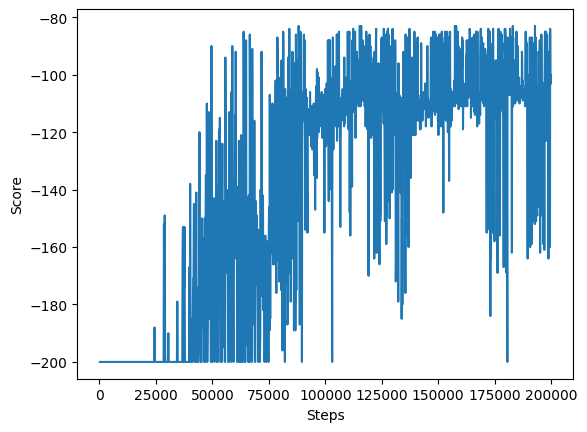

In [ ]:
all_rewards2 = np.array(all_rewards2)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards2[:, 0], all_rewards2[:, 1])

In [ ]:
env = Recorder(env2, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net2.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net2.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-97.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  87%|████████▋ | 86/99 [00:00<00:00, 171.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./video/1717781344.239608.mp4, 720000 bytes wanted but 0 bytes read,at frame 98/99, at time 3.27/3.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                             

Moviepy - Done !
Moviepy - video ready __temp__.mp4


# Báo cáo

Trong file này, em đã thay đổi mạng neuron từ 64 neuron sang 128 neuron và thay chèn thêm một lớp phụ giữa lớp input và lớp output.

Còn về các tham số, em đã tùy chỉnh một bố tham số mới, cụ thể: tăng learning rate, tăng batch_size và min_replay_size và max_num_steps (bộ tham số mới có số 2 ở trong tên để phân biệt với bộ tham số của CartPole-v0).

Trong quá trình train, em nhận thấy giá trị average reward chỉ có thể tăng lên mức khoảng -102 điểm sau khoảng 170000 steps, sau đó sẽ lại giảm xuống, nên có thể chỉ cần đặt max_num_steps = 170000.

Sau khi train xong, xe đã có thể chạy lên đỉnh đồi như trong video trên.